# Рекомендация тарифов сотовой связи

## Изучение данных

In [42]:
import pandas as pd
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree

Загрузим данные, выведем основную информацию и описательные статистики. Оценим формат данных.

In [10]:
df = pd.read_csv('/Users/anshilina/Documents/users_behavior.csv')
    
display(df.head())

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [12]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Посмотрим на количество пропусков и явные дубликаты.

In [13]:
print(df.isna().sum())

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64


In [14]:
print('Кол-во явных дубликатов:', df.duplicated().sum())

Кол-во явных дубликатов: 0


Далее построим распределения независимых и зависимой переменных.

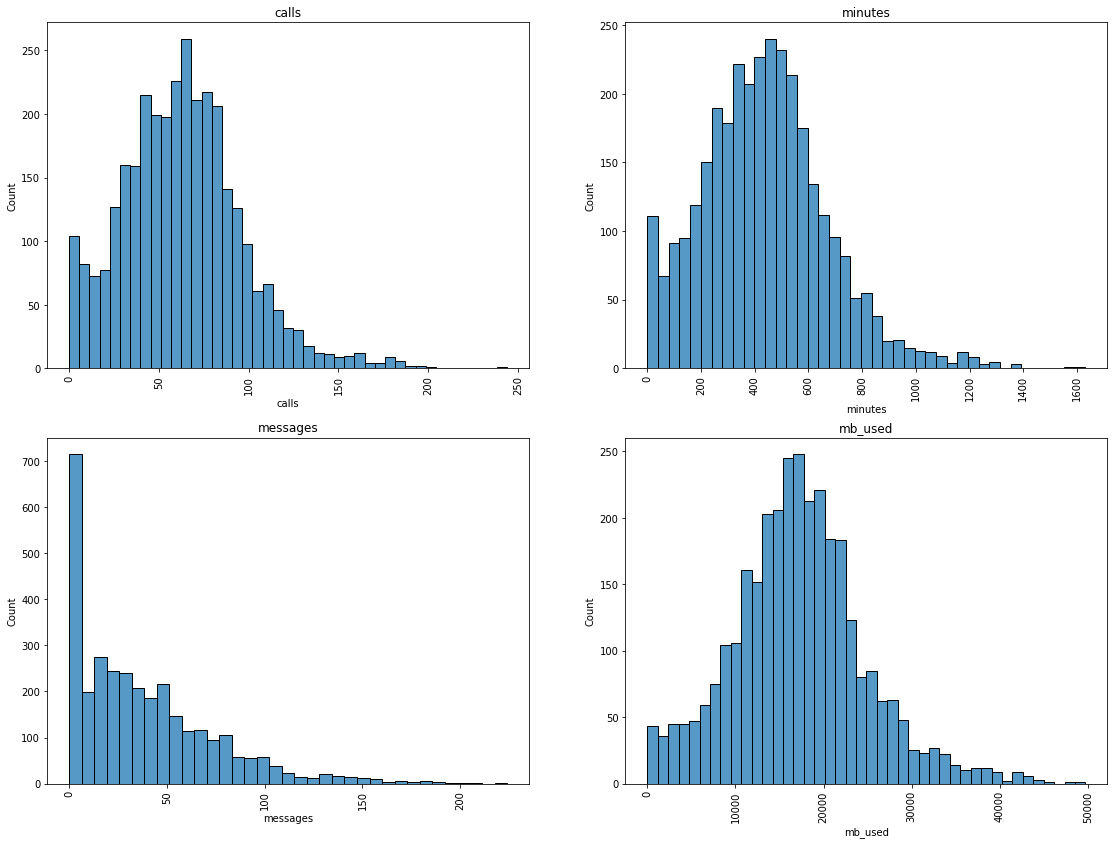

In [15]:
_, axs = plt.subplots(2, 2, figsize=(19,14))
axs = axs.ravel()
names = df.drop(['is_ultra'], axis=1).columns

for i in range(len(names)):
    ax = axs[i]
    sns.histplot(ax=ax, x=df[names[i]], data=df)
    ax.tick_params(axis='x', labelrotation = 90)
    ax.set_title(names[i])

In [16]:
print('Уникальные значения зависимой переменной:', df['is_ultra'].unique())

Уникальные значения зависимой переменной: [0 1]


Cтоит отметить, что у нас несбалансированная выборка. Тех, кто использует тариф "Ультра" гораздо меньше чем тех, кто пользуется "Смартом".

In [17]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

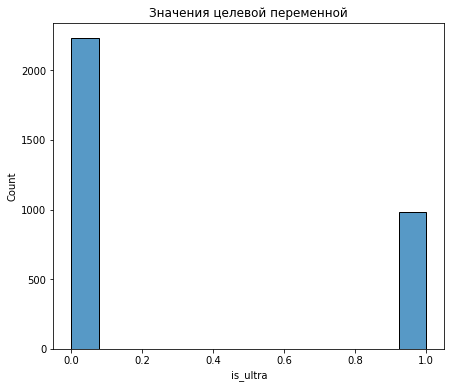

In [18]:
plt.figure(figsize=(7,6))
sns.histplot(x=df['is_ultra'], data=df)
plt.title('Значения целевой переменной')
plt.show()

**Вывод:** Формат данных не требует изменений, в данных нет пропусков и явных дубликатов. Распределения переменных `calls`, `minutes`, `mb_users` стремятся к нормальному, скошены вправо. Распределение переменной `messages` сильно скошено вправо – люди чаще всего не пользуются смс. Зависимая переменная `is_ultra` – бинарная и принимает значение 1, если человек пользуется тарифом "Ультра". Поскольку переменная бинарная, нам предстоит решить задачу классификации.

Мы также видим, что переменная `minutes` сильно скореллирована с переменной `calls`. Это может исказить результаты линейного классификатора. Удалим один из признаков (`minutes`), чтобы избежать мультиколлинеарности.

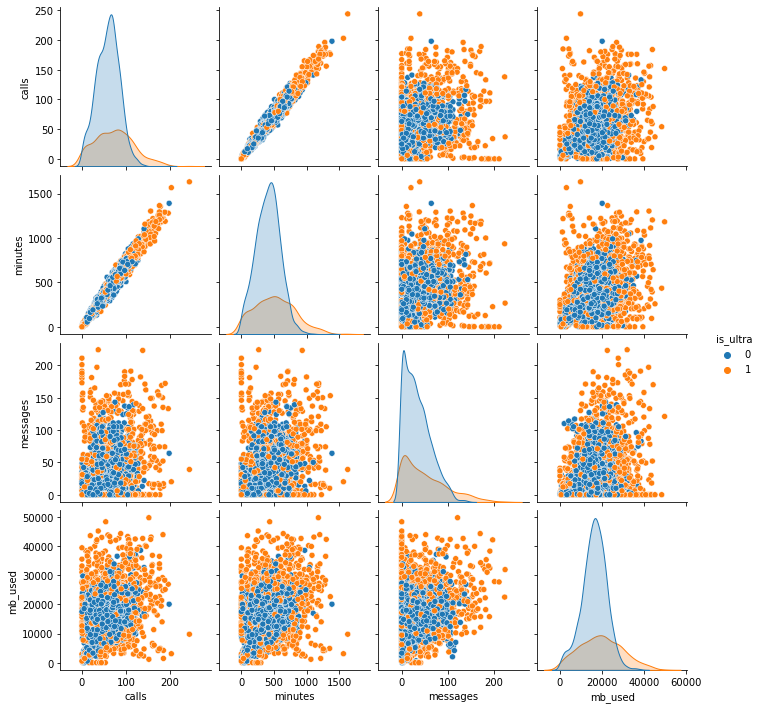

In [19]:
sns.pairplot(df, hue='is_ultra')
plt.show()

In [20]:
df = df.drop('minutes', axis=1).copy()

## Разбейте данные на выборки

Выделим значения зависимой переменной и присвоим их переменной `target`, массив со значениями независимых переменных сохраним в переменной `features`.

In [22]:
target = df['is_ultra']
features = df.drop(['is_ultra'], axis = 1)

Разделим выборку на обучающую, валидационную, тестовую в соотношении 60%, 20%, 20% соответсвенно. 

In [23]:
features_train, features_valid, target_train, target_valid = \
train_test_split(features, target, test_size=0.4, random_state=42)

features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid, target_valid, test_size=0.5, random_state=42)

Проверим размеры получившихся выборок.

In [24]:
print(features_train.shape, target_train.shape)
print(features_valid.shape, target_valid.shape)
print(features_test.shape, target_test.shape)

(1928, 3) (1928,)
(643, 3) (643,)
(643, 3) (643,)


Проверим не совпадают ли получившиеся выборки.

In [25]:
(features_valid.reset_index(drop=True) == features_test.reset_index(drop=True)).all().sum()

0

In [26]:
(target_valid.reset_index(drop=True) == target_test.reset_index(drop=True)).all().sum()

0

Проверим, сохраняется ли изначальное распределение зависимой переменной в трёх выборках.

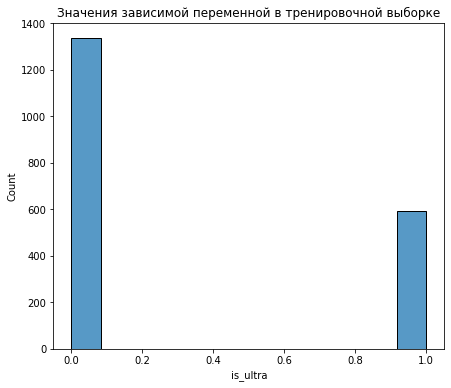

In [28]:
plt.figure(figsize=(7,6))
sns.histplot(x=target_train)
plt.title('Значения зависимой переменной в тренировочной выборке')
plt.show()

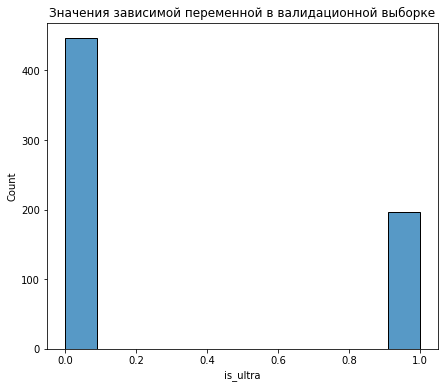

In [30]:
plt.figure(figsize=(7,6))
sns.histplot(x=target_valid)
plt.title('Значения зависимой переменной в валидационной выборке')
plt.show()

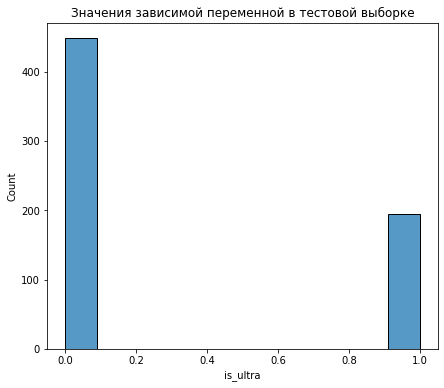

In [31]:
plt.figure(figsize=(7,6))
sns.histplot(x=target_test)
plt.title('Значения зависимой переменной в тестовой выборке')
plt.show()

**Вывод:** Мы успешно справились с поставленной задачей. Выборки для обучения, валидации и теста готовы.

## Обучение моделей

Первая модель, которую мы будем исследовать – дерево решений. Для начала посмотрим, по какому принципу дерево решений будет делить объекты.

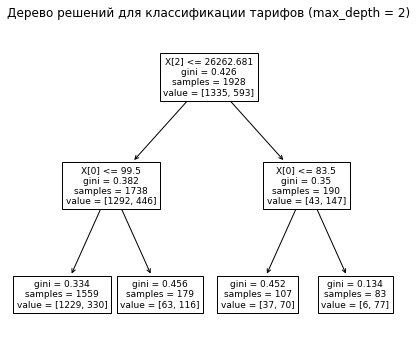

In [32]:
plt.figure(figsize=(7,6))
model_tree_plot = DecisionTreeClassifier(max_depth=2, random_state=42)
model_tree_plot.fit(features_train, target_train)
tree.plot_tree(model_tree_plot)
plt.title('Дерево решений для классификации тарифов (max_depth = 2)')
plt.show()

В цикле переберем гиперпараметры: `max_depth` (максимальная глубина дерева), `min_samples_split` (минимальное количество наблюдений для дальнейшего деления), `min_samples_leaf` (минимальное количество наблюдений в каждом листе дерева решений).

In [33]:
%%time

train = []
validation = []
best_model_tree = None
accuracy = 0
for depth in range(1, 15):
    for split in range(2, 5):
        for leaf in range(1,4):
            model_tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
            model_tree.fit(features_train, target_train)
            new_accuracy = model_tree.score(features_valid, target_valid)
            if new_accuracy > accuracy:
                accuracy = new_accuracy
                best_model_tree = model_tree
                train.append(model_tree.score(features_train, target_train))
                validation.append(new_accuracy)

print("Accuracy наилучшей модели на валидационной выборке:", accuracy)

Accuracy наилучшей модели на валидационной выборке: 0.8133748055987559
CPU times: user 757 ms, sys: 4.81 ms, total: 762 ms
Wall time: 760 ms


Посмотрим, как менялось качество лучших моделей дерева решений на обучающей и валидационной выборке.

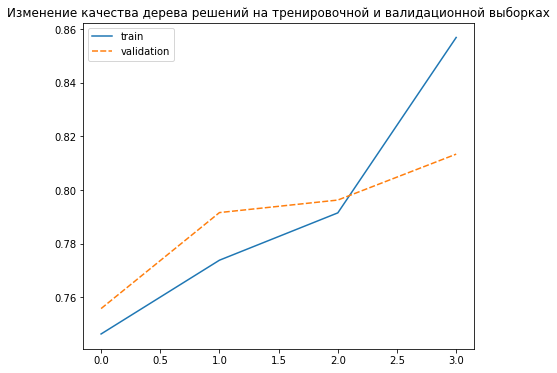

In [35]:
plt.figure(figsize=(7,6))
dat_plot = pd.DataFrame({'train':train, 'validation':validation})
sns.lineplot(data=dat_plot)
plt.title('Изменение качества дерева решений на тренировочной и валидационной выборках')
plt.show()

В результате доля правильных ответов на валидационной выборке высокая. Выведем значения гиперпараметров лучшего дерева решений.

In [24]:
best_model_tree

DecisionTreeClassifier(max_depth=8, random_state=42)

Видимо значение гиперпараметров `min_samples_split` и `min_samples_leaf` совпало с дефолтным.

Теперь рассмотрим можель случайного леса. В цикле переберем гиперпараметры: `max_depth` (максимальная глубина дерева), `min_samples_split` (минимальное количество наблюдений для дальнейшего деления), `min_samples_leaf` (минимальное количество наблюдений в каждом листе дерева решений), а также параметр `n_estimators`, который отвечает за количество обучающихся деревьев.

In [36]:
%%time

train = []
validation = []
best_model_forest = None
accuracy = 0
for depth in range(1, 15):
    for split in range(2, 5):
        for leaf in range(1,4):
            for est in range(10, 150, 10):
                model_forest = RandomForestClassifier(n_estimators = est, max_depth=depth, min_samples_split=split, min_samples_leaf=leaf, random_state=42)
                model_forest.fit(features_train, target_train)
                new_accuracy = model_forest.score(features_valid, target_valid)
                if new_accuracy > accuracy:
                    accuracy = new_accuracy
                    best_model_forest = model_forest
                    train.append(model_forest.score(features_train, target_train))
                    validation.append(new_accuracy)

print("Accuracy наилучшей модели на валидационной выборке:", accuracy)

Accuracy наилучшей модели на валидационной выборке: 0.8242612752721618
CPU times: user 4min 31s, sys: 1.49 s, total: 4min 32s
Wall time: 4min 32s


Посмотрим, как менялось качество лучших моделей дерева решений на обучающей и валидационной выборке.

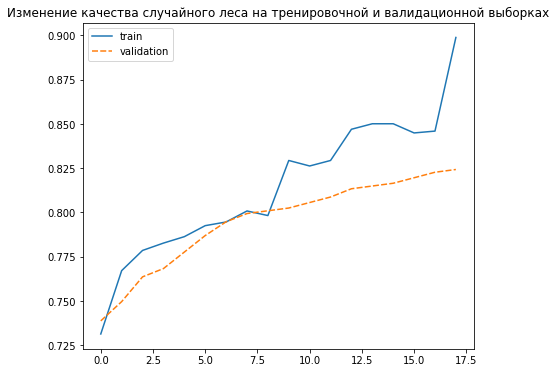

In [37]:
plt.figure(figsize=(7,6))
dat_plot = pd.DataFrame({'train':train, 'validation':validation})
sns.lineplot(data=dat_plot)
plt.title('Изменение качества случайного леса на тренировочной и валидационной выборках')
plt.show()

Доля правильных ответов на валидационной выборке еще выше. Выведем значения гиперпараметров лучшего дерева решений.

In [27]:
best_model_forest

RandomForestClassifier(max_depth=14, min_samples_leaf=2, n_estimators=40,
                       random_state=42)

В заключение рассмотрим логичстическую регрессию. Качество на этой модели по сравнению с деревом решений и случайным лесом самое низкое.

In [38]:
%%time 

model_log = LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000) 
model_log.fit(features_train, target_train)
print("Accuracy на валидационной выборке:", model_log.score(features_valid, target_valid))

Accuracy на валидационной выборке: 0.7247278382581649
CPU times: user 20.9 ms, sys: 4.57 ms, total: 25.5 ms
Wall time: 25.8 ms


## Проверка модели на тестовой выборке

Самый лучший показатель на обучающей выборки у модели случайного леса. Выберем эту модель и проверим её на тестовой выборке. 

Качество случайного леса на тестовой выборке чуть ниже, чем на валидационной, но по-прежнему высокое (0,8). Из графика видно, сколько случайный лес даёт ложно-положительных и ложно-отрицательных ответов.

In [55]:
print('Качество случайного леса на тестовой выборке:',best_model_forest.score(features_test, target_test))

Качество случайного леса на тестовой выборке: 0.8087091757387247


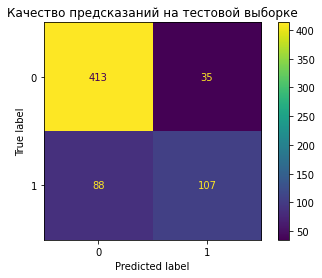

In [56]:
cm = confusion_matrix(target_test, best_model_forest.predict(features_test), labels=best_model_forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_model_forest.classes_)
disp.plot()
plt.title('Качество предсказаний на тестовой выборке')
plt.show()

## Вывод

Таким образом, обучив три модели для решения задачи классификации мы обнаружили, что относительно всех моделей дерево решений относительно быстро обучается и показывает неплохую долю верных ответов. Но если не брать во внимание скорость обучения с задачей классификации лучше всех справилась модель случайного леса, о чем говорит меньшее количество ложно-положительных и ложно-отрицательных ответов.

| Тип модели | Скорость обучения | Accuracy |
| --- | --- | --- |
| Дерево решений | средняя | средняя|
| Случайный лес | низкая | высокая |
| Логистическая регрессия | высокая | низкая |

## Проверим модель на адекватность

Проверим модель на адекватность с использованием модели DummyClassifier, которая делает предсказания, не выявляя закономерности в данных. 

In [60]:
dummy_clf = DummyClassifier(strategy='uniform', random_state=42)
dummy_clf.fit(features_train, target_train)
dummy_clf.score(features_test, target_test)

0.5101088646967341

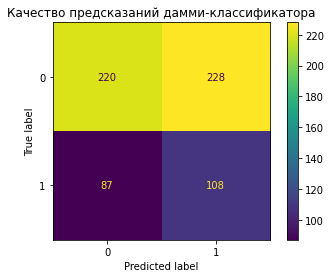

In [61]:
cm = confusion_matrix(target_test, dummy_clf.predict(features_test), labels=dummy_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dummy_clf.classes_)
disp.plot()
plt.title('Качество предсказаний дамми-классификатора')
plt.show()

Итак, мы явно улучшили качество классификации, обратившись к другим моделям.